# Mortgage Forecasting - Data Wrangling
## HMDA Data Processing and Aggregation

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8') # Set up plotting
sns.set_palette("husl")
%matplotlib inline


## 1. Configuration and Setup

In [15]:
# Load configuration
with open('../config/model_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

print("Project Configuration:")
print(f"Target Geography: {config['data']['target_geography']}")
print(f"Geography Code: {config['data']['geography_code']}")
print(f"Years: {config['data']['hmda_years']}")

Project Configuration:
Target Geography: NEW ORLEANS-METAIRIE - LOUISIANA, LA
Geography Code: 35380
Years: [2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [16]:
import yaml
from pathlib import Path

# Configuration data matching the available sample files
config_data = {
    'data': {
        'target_geography': "New Orleans-Metairie, Louisiana", # Updated as per user clarification
        'geography_type': "msa",
        'geography_code': "35380", # Updated as per user clarification
        'hmda_years': [2018, 2019, 2020, 2021, 2022, 2023, 2024] # Based on available years in sample_data
    }
}

# Create config directory if it doesn't exist
config_dir = Path('./config')
config_dir.mkdir(parents=True, exist_ok=True)

# Define the path for the config file within the new directory
config_file_path = config_dir / 'model_config.yaml'

# Write the configuration to the YAML file
with open(config_file_path, 'w') as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Created configuration file: {config_file_path.resolve()}")

Created configuration file: /home/yahnik_rohse/mortgage-forecasting/notebooks/config/model_config.yaml


## 2. HMDA Data Loading Function

In [18]:
def load_hmda_year(year):
    """Load HMDA data for a specific year"""
    # Use the geography_code from the config and adjust the file path
    geography_code = config['data']['geography_code']
    # Corrected file path to look directly in ../data/raw/
    file_path = Path(f"../data/raw/{year}_msamd_{geography_code}.csv")

    if not file_path.exists():
        print(f"File not found: {file_path}")
        return None

    print(f"Loading MSAMD {year} (Code: {geography_code})...")

    # Read with optimized dtypes
    dtype_dict = {
        'loan_amount': 'float64',
        'action_taken': 'int64',
        'state_code': 'str',
        'county_code': 'str',
        'msa_md': 'str',
        'applicant_income_000s': 'float64',
        'as_of_year': 'int64'
    }

    try:
        df = pd.read_csv(file_path, dtype=dtype_dict, low_memory=False)
        print(f"  Loaded {len(df):,} records")
        return df
    except Exception as e:
        print(f"  Error loading {year}: {e}")
        return None

# Load all years
all_data = []
for year in config['data']['hmda_years']:
    df_year = load_hmda_year(year)
    if df_year is not None:
        all_data.append(df_year)

if all_data:
    hmda_raw = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal combined records: {len(hmda_raw):,}")
else:
    print("No data loaded!")
    hmda_raw = pd.DataFrame()

Loading MSAMD 2018 (Code: 35380)...
  Loaded 50,498 records
Loading MSAMD 2019 (Code: 35380)...
  Loaded 54,565 records
Loading MSAMD 2020 (Code: 35380)...
  Loaded 80,867 records
Loading MSAMD 2021 (Code: 35380)...
  Loaded 81,003 records
Loading MSAMD 2022 (Code: 35380)...
  Loaded 50,800 records
Loading MSAMD 2023 (Code: 35380)...
  Loaded 34,753 records
Loading MSAMD 2024 (Code: 35380)...
  Loaded 24,577 records

Total combined records: 377,063


## 3. Data Exploration and Understanding

In [19]:
if not hmda_raw.empty:
    print("Data Overview:")
    print(f"Shape: {hmda_raw.shape}")
    print("\nColumns:")
    print(hmda_raw.columns.tolist())

    print("\nSample data:")
    display(hmda_raw.head())

    print("\nData types:")
    display(hmda_raw.dtypes)

Data Overview:
Shape: (377063, 99)

Columns:
['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code', 'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category', 'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken', 'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage', 'open-end_line_of_credit', 'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'total_points_and_fees', 'origination_charges', 'discount_points', 'lender_credits', 'loan_term', 'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'construction_method', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'multifamily_affordable_units', 'income', 'd

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2018,KB1H1DSPRFMYMCUFXT09,35380,LA,22089,2.208906e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7396,12.59,65700,154.0,2168,2597,30
1,2018,KB1H1DSPRFMYMCUFXT09,35380,LA,22051,2.205103e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,8566,81.27,65700,112.0,2453,2930,32
2,2018,KB1H1DSPRFMYMCUFXT09,35380,LA,22051,2.205103e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3341,100.00,65700,53.0,1009,1379,44
3,2018,KB1H1DSPRFMYMCUFXT09,35380,LA,22051,2.205103e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,8812,42.84,65700,136.0,2721,3038,24
4,2018,KB1H1DSPRFMYMCUFXT09,35380,LA,22071,2.207100e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,3985,62.86,65700,110.0,974,1356,43



Data types:


activity_year                          int64
lei                                   object
derived_msa-md                         int64
state_code                            object
county_code                           object
                                      ...   
ffiec_msa_md_median_family_income      int64
tract_to_msa_income_percentage       float64
tract_owner_occupied_units             int64
tract_one_to_four_family_homes         int64
tract_median_age_of_housing_units      int64
Length: 99, dtype: object

In [20]:
# Check action_taken distribution
if 'action_taken' in hmda_raw.columns:
    print("Action Taken Distribution:")
    action_counts = hmda_raw['action_taken'].value_counts().sort_index()

    # Common HMDA action codes
    action_map = {
        1: 'Loan originated',
        2: 'Application approved but not accepted',
        3: 'Application denied',
        4: 'Application withdrawn by applicant',
        5: 'File closed for incompleteness',
        6: 'Purchased loan',
        7: 'Preapproval request denied',
        8: 'Preapproval request approved but not accepted'
    }

    for code, count in action_counts.items():
        desc = action_map.get(code, 'Unknown')
        print(f"  {code}: {desc} - {count:,} records ({count/len(hmda_raw)*100:.1f}%)")

Action Taken Distribution:
  1: Loan originated - 191,271 records (50.7%)
  2: Application approved but not accepted - 9,653 records (2.6%)
  3: Application denied - 56,100 records (14.9%)
  4: Application withdrawn by applicant - 51,716 records (13.7%)
  5: File closed for incompleteness - 19,176 records (5.1%)
  6: Purchased loan - 48,590 records (12.9%)
  7: Preapproval request denied - 126 records (0.0%)
  8: Preapproval request approved but not accepted - 431 records (0.1%)


## 4. Data Filtering and Cleaning

In [21]:
def filter_originated_loans(df):
    """Filter for originated loans only (action_taken = 1)"""
    if 'action_taken' not in df.columns:
        print("Warning: 'action_taken' column not found")
        return df

    original_count = len(df)
    df_originated = df[df['action_taken'] == 1].copy()

    print(f"Filtered to originated loans: {len(df_originated):,} records ({len(df_originated)/original_count*100:.1f}% of total)")

    return df_originated

def filter_target_geography(df, geography_type, geography_code):
    """Filter for target geography"""
    if geography_type == 'msa':
        if 'derived_msa-md' not in df.columns:
            print("Warning: 'derived_msa-md' column not found")
            return df
        df_geo = df[df['derived_msa-md'] == int(geography_code)].copy()
        print(f"Filtered to MSA {geography_code}: {len(df_geo):,} records")
    else:  # state
        if 'state_code' not in df.columns:
            print("Warning: 'state_code' column not found")
            return df
        df_geo = df[df['state_code'] == geography_code].copy()
        print(f"Filtered to state {geography_code}: {len(df_geo):,} records")

    return df_geo

# Apply filters
if not hmda_raw.empty:
    print("Applying data filters...")

    # Filter for originated loans
    hmda_originated = filter_originated_loans(hmda_raw)

    # Filter for target geography
    hmda_filtered = filter_target_geography(
        hmda_originated,
        config['data']['geography_type'],
        config['data']['geography_code']
    )

    print(f"\nFinal filtered dataset: {len(hmda_filtered):,} records")

Applying data filters...
Filtered to originated loans: 191,271 records (50.7% of total)
Filtered to MSA 35380: 191,271 records

Final filtered dataset: 191,271 records


## 5. Data Quality Checks

In [22]:
if not hmda_filtered.empty:
    print("Data Quality Checks:")

    # Check for missing values
    print("\nMissing Values:")
    missing_data = hmda_filtered.isnull().sum()
    for col, missing_count in missing_data.items():
        if missing_count > 0:
            print(f"  {col}: {missing_count:,} missing ({missing_count/len(hmda_filtered)*100:.1f}%)")

    # Check loan amount distribution
    if 'loan_amount' in hmda_filtered.columns:
        print(f"\nLoan Amount Statistics:")
        print(f"  Min: ${hmda_filtered['loan_amount'].min():,.0f}")
        print(f"  Mean: ${hmda_filtered['loan_amount'].mean():,.0f}")
        print(f"  Median: ${hmda_filtered['loan_amount'].median():,.0f}")
        print(f"  Max: ${hmda_filtered['loan_amount'].max():,.0f}")

        # Check for zeros or negative values
        zero_or_negative = (hmda_filtered['loan_amount'] <= 0).sum()
        if zero_or_negative > 0:
            print(f"  WARNING: {zero_or_negative} records with zero or negative loan amounts")

    # Check temporal coverage
    if 'activity_year' in hmda_filtered.columns:
        print(f"\nYearly Distribution:")
        year_counts = hmda_filtered['activity_year'].value_counts().sort_index()
        for year, count in year_counts.items():
            print(f"  {year}: {count:,} records")

Data Quality Checks:

Missing Values:
  state_code: 65 missing (0.0%)
  county_code: 77 missing (0.0%)
  census_tract: 22 missing (0.0%)
  conforming_loan_limit: 1,469 missing (0.8%)
  loan_to_value_ratio: 13,479 missing (7.0%)
  interest_rate: 757 missing (0.4%)
  rate_spread: 16,616 missing (8.7%)
  total_loan_costs: 29,886 missing (15.6%)
  total_points_and_fees: 181,326 missing (94.8%)
  origination_charges: 29,958 missing (15.7%)
  discount_points: 114,005 missing (59.6%)
  lender_credits: 131,825 missing (68.9%)
  loan_term: 1,538 missing (0.8%)
  prepayment_penalty_term: 177,377 missing (92.7%)
  intro_rate_period: 159,998 missing (83.6%)
  property_value: 8,978 missing (4.7%)
  multifamily_affordable_units: 181,482 missing (94.9%)
  income: 18,408 missing (9.6%)
  debt_to_income_ratio: 20,310 missing (10.6%)
  applicant_ethnicity-1: 32 missing (0.0%)
  applicant_ethnicity-2: 186,826 missing (97.7%)
  applicant_ethnicity-3: 191,134 missing (99.9%)
  applicant_ethnicity-4: 191,26

## 6. Time Series Aggregation

In [23]:
def create_quarterly_series(df):
    """Aggregate loan volume by quarter"""
    if df.empty:
        return pd.DataFrame()

    df_agg = df.copy()

    # For simplicity, we'll assign records randomly to quarters within their year
    # In practice, you might have actual application dates
    np.random.seed(42)  # for reproducibility

    # Generate random quarter numbers (1 to 4) for each row
    random_quarters = np.random.randint(1, 5, size=len(df_agg))

    # Create a PeriodIndex for quarter-end dates, which is more robust
    quarter_period_idx = pd.PeriodIndex(year=df_agg['activity_year'], quarter=random_quarters, freq='Q')
    df_agg['quarter_date'] = quarter_period_idx.to_timestamp(how='end')

    # Aggregate by quarter
    quarterly = df_agg.groupby('quarter_date')['loan_amount'].agg([
        ('total_loan_volume', 'sum'),
        ('loan_count', 'count'),
        ('avg_loan_size', 'mean')
    ]).reset_index()

    quarterly = quarterly.rename(columns={'quarter_date': 'date'})
    quarterly = quarterly.sort_values('date')

    # Create complete time series
    start_date = quarterly['date'].min()
    end_date = pd.Timestamp('2024-12-31')  # Fixed end date to 2024-12-31
    all_quarters = pd.date_range(start=start_date, end=end_date, freq='Q')

    complete_series = pd.DataFrame({'date': all_quarters})
    complete_series = complete_series.merge(quarterly, on='date', how='left')

    # Fill missing values with 0 (assuming no loans in that quarter)
    complete_series['total_loan_volume'] = complete_series['total_loan_volume'].fillna(0)
    complete_series['loan_count'] = complete_series['loan_count'].fillna(0)

    return complete_series

# Create quarterly time series
if not hmda_filtered.empty:
    quarterly_series = create_quarterly_series(hmda_filtered)

    print("Quarterly Time Series:")
    print(f"Time range: {quarterly_series['date'].min()} to {quarterly_series['date'].max()}")
    print(f"Total quarters: {len(quarterly_series)}")

    display(quarterly_series.head(10))

    # Summary statistics
    print("\nQuarterly Volume Summary:")
    print(f"Total volume: ${quarterly_series['total_loan_volume'].sum():,.0f}")
    print(f"Average quarterly volume: ${quarterly_series['total_loan_volume'].mean():,.0f}")
    print(f"Max quarterly volume: ${quarterly_series['total_loan_volume'].max():,.0f}")
    print(f"Min quarterly volume: ${quarterly_series['total_loan_volume'].min():,.0f}")

Quarterly Time Series:
Time range: 2018-03-31 23:59:59.999999999 to 2024-09-30 23:59:59.999999999
Total quarters: 27


,date,total_loan_volume,loan_count,avg_loan_size
0,2018-03-31 23:59:59.999999999,1.392470e+09,6214,224085.934986
1,2018-06-30 23:59:59.999999999,1.348705e+09,6153,219194.701771
2,2018-09-30 23:59:59.999999999,1.332650e+09,6074,219402.370761
3,2018-12-31 23:59:59.999999999,1.328910e+09,6140,216434.853420
4,2019-03-31 23:59:59.999999999,1.745240e+09,7026,248397.381156
5,2019-06-30 23:59:59.999999999,1.726525e+09,6907,249967.424352
6,2019-09-30 23:59:59.999999999,1.685220e+09,7064,238564.552661
7,2019-12-31 23:59:59.999999999,1.705825e+09,7033,242545.855254
8,2020-03-31 23:59:59.999999999,2.784105e+09,10955,254140.118667
9,2020-06-30 23:59:59.999999999,2.832370e+09,11116,254801.187478



Quarterly Volume Summary:
Total volume: $48,620,430,000
Average quarterly volume: $1,800,756,667
Max quarterly volume: $2,902,970,000
Min quarterly volume: $741,345,000


## 7. Save Processed Data

In [24]:
# Save processed data
if not quarterly_series.empty:
    output_path = Path("../data/processed/quarterly_mortgage_volume.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)

    quarterly_series.to_csv(output_path, index=False)
    print(f"\nProcessed data saved to: {output_path}")

    # Also save the filtered HMDA data for future use
    filtered_path = Path("../data/processed/filtered_hmda_data.csv")
    hmda_filtered.to_csv(filtered_path, index=False)
    print(f"Filtered HMDA data saved to: {filtered_path}")


Processed data saved to: ../data/processed/quarterly_mortgage_volume.csv
Filtered HMDA data saved to: ../data/processed/filtered_hmda_data.csv


## 8. Quick Visualization

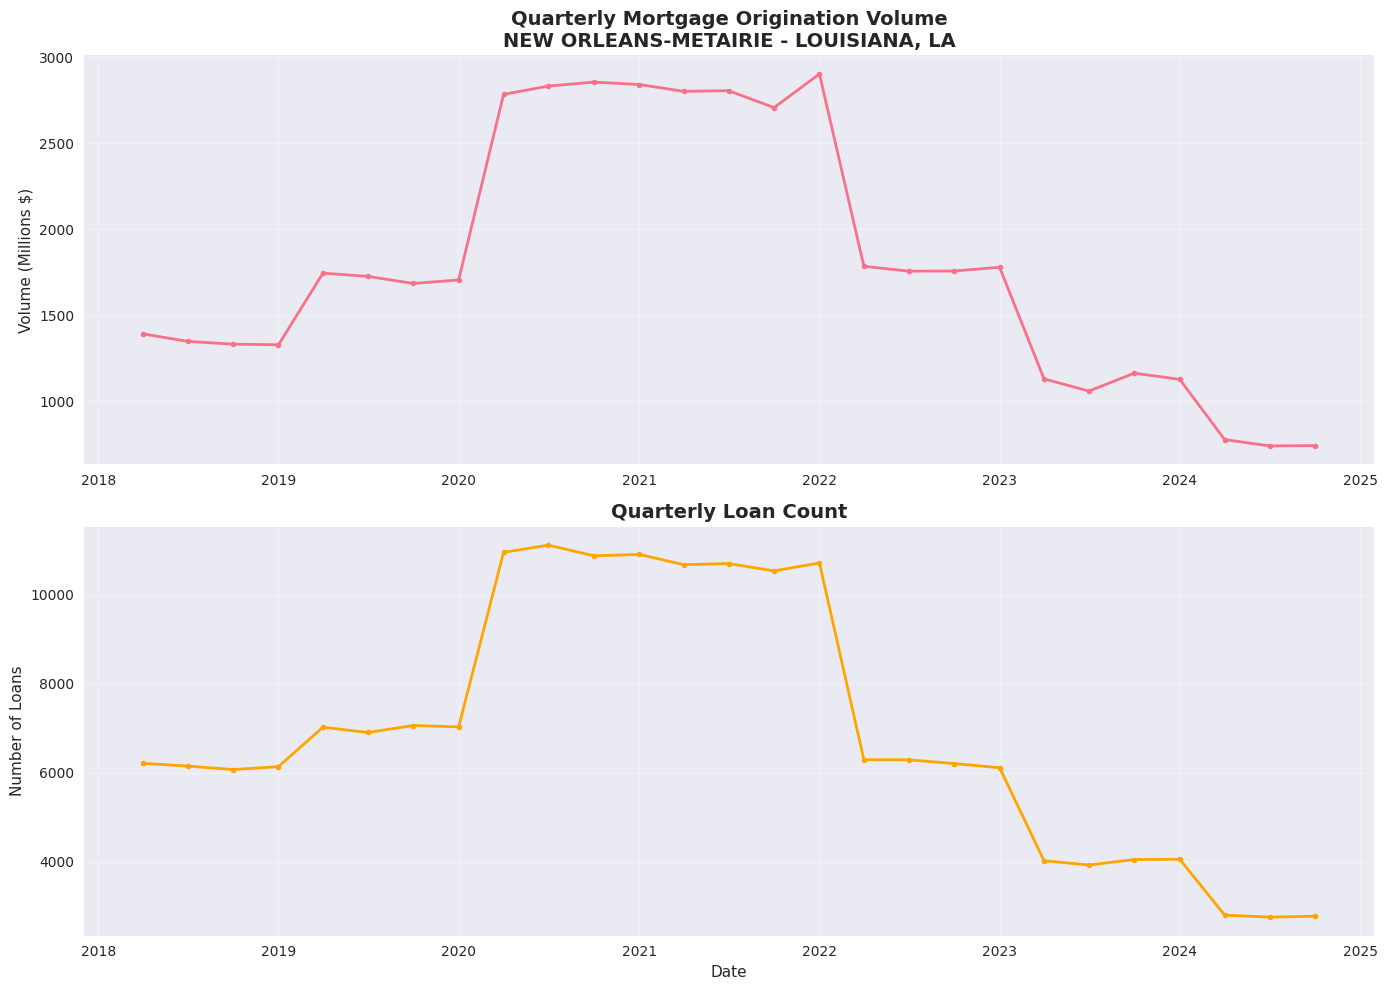

In [25]:
if not quarterly_series.empty:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Total loan volume
    ax1.plot(quarterly_series['date'], quarterly_series['total_loan_volume'] / 1e6,
             linewidth=2, marker='o', markersize=4)
    ax1.set_title(f'Quarterly Mortgage Origination Volume\n{config["data"]["target_geography"]}',
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('Volume (Millions $)')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Loan count
    ax2.plot(quarterly_series['date'], quarterly_series['loan_count'],
             linewidth=2, marker='o', markersize=4, color='orange')
    ax2.set_title('Quarterly Loan Count', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Loans')
    ax2.set_xlabel('Date')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Save the plot
    fig.savefig('../data_wrangling_timeseries.png', dpi=300, bbox_inches='tight')

## Summary

In this notebook we:
1. Loaded and combined multiple years of HMDA data
2. Filtered for originated loans in our target geography
3. Performed data quality checks
4. Aggregated to quarterly time series
5. Saved processed data for analysis
6. Created initial visualizations

The data is now ready for exploratory analysis in the next notebook.